In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
base_path = './data/ML-1M/'

ratings = pd.read_csv(base_path+'ratings.csv', sep='\t', 
                      encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'rating'])

users = pd.read_csv(base_path+'users.csv', sep='\t', 
                    encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 
                             'age_desc', 'occ_desc'])

movies = pd.read_csv(base_path+'movies.csv', sep='\t', 
                     encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [7]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [8]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [9]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Plot the wordcloud

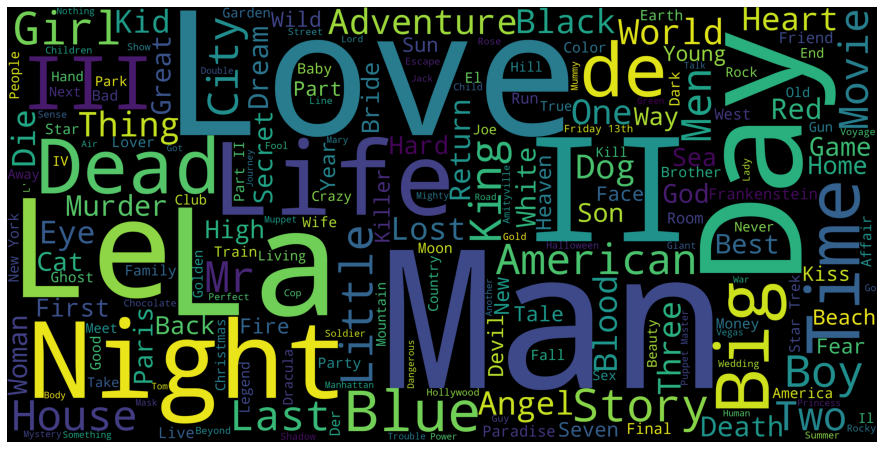

In [10]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Genre-based recommendations

In [ ]:
# Import libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')

# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

# Movie feature vector
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, 
                     stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

# Movie similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# 1-d array of movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function to return top-k most similar movies
def genre_recommendations(title, topk=20):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:topk+1]
  movie_indices = [i[0] for i in sim_scores]
  return titles.iloc[movie_indices].reset_index(drop=True)

In [15]:
# Checkout the results
# genre_recommendations('Good Will Hunting (1997)')
genre_recommendations('Toy Story (1995)')
# genre_recommendations('Saving Private Ryan (1998)')

0                Aladdin and the King of Thieves (1996)
1                              American Tail, An (1986)
2            American Tail: Fievel Goes West, An (1991)
3                             Rugrats Movie, The (1998)
4                                  Bug's Life, A (1998)
5                                    Toy Story 2 (1999)
6                                 Saludos Amigos (1943)
7                                    Chicken Run (2000)
8        Adventures of Rocky and Bullwinkle, The (2000)
9                                 Goofy Movie, A (1995)
10                                         Balto (1995)
11                              Gumby: The Movie (1995)
12                            Swan Princess, The (1994)
13                                     Pinocchio (1940)
14                               Aristocats, The (1970)
15                              Oliver & Company (1988)
16    Land Before Time III: The Time of the Great Gi...
17          Winnie the Pooh and the Blustery Day

Simple collaborative filtering

In [36]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

# Randomly sample 1% for faster processing
small_data = ratings.sample(frac=0.01)

# Split into train and test
train_data, test_data = train_test_split(small_data, test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
test_data_matrix = test_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Create user similarity using Pearson correlation
user_correlation = 1 - pairwise_distances(train_data_matrix, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0

# Create item similarity using Pearson correlation
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0

# Function to predict ratings
def predict(ratings, similarity, type='user'):
  if type == 'user':
    mean_user_rating = ratings.mean(axis=1)
    # Use np.newaxis so that mean_user_rating has same format as ratings
    ratings_diff = (ratings - mean_user_rating.values[:, np.newaxis])
    pred = mean_user_rating.values[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
  elif type == 'item':
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
  return pred

# Function to calculate RMSE
def rmse(pred, actual):
  # Ignore nonzero terms.
  pred = pd.DataFrame(pred).values
  actual = actual.values
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return sqrt(mean_squared_error(pred, actual))

# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the train data
print('User-based CF RMSE Train: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE Train: ' + str(rmse(item_prediction, train_data_matrix)))

# RMSE on the test data
print('User-based CF RMSE Test: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE Test: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE Train: 2.6156258817338545
Item-based CF RMSE Train: 2.8395461928591756
User-based CF RMSE Test: 3.740786194256653
Item-based CF RMSE Test: 3.7432481961974267


SVD matrix factorization based collaborative filtering

In [49]:
!pip install surprise

     |████████████████████████████████| 11.8MB 8.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618266 sha256=8ea4c56743b89b02a764481272bfcb2f25f76e68574c6d695397e9579c503de3
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [51]:
from scipy.sparse.linalg import svds

# Create the interaction matrix
interactions = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(pd.DataFrame(interactions.values).head())

# De-normalize the data (normalize by each users mean)
user_ratings_mean = np.mean(interactions.values, axis=1)
interactions_normalized = interactions.values - user_ratings_mean.reshape(-1, 1)
print(pd.DataFrame(interactions_normalized).head())

# Calculating SVD
U, sigma, Vt = svds(interactions_normalized, k=50)
sigma = np.diag(sigma)

# Make predictions from the decomposed matrix by matrix multiply U, Σ, and VT 
# back to get the rank k=50 approximation of A.
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(all_user_predicted_ratings, columns=interactions.columns)
print(preds.head().values)

# Get the movie with the highest predicted rating
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
  
  # Get and sort the user's predictions
  user_row_number = userID - 1 # User ID starts at 1, not 0
  sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
  
  # Get the user's data and merge in the movie information.
  user_data = original_ratings[original_ratings.user_id == (userID)]
  user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                    sort_values(['rating'], ascending=False)
                )

  print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
  print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
  
  # Recommend the highest predicted rating movies that the user hasn't seen yet.
  recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
        merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
              left_on = 'movie_id',
              right_on = 'movie_id').
        rename(columns = {user_row_number: 'Predictions'}).
        sort_values('Predictions', ascending = False).
                      iloc[:num_recommendations, :-1]
                    )

  return user_full, recommendations

# Let's try to recommend 20 movies for user with ID 1310
already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 20)

# Top 20 movies that User 1310 has rated 
print(already_rated.head(20))

# Top 20 movies that User 1310 hopefully will enjoy
print(predictions)

   0     1     2     3     4     5     ...  3700  3701  3702  3703  3704  3705
0   5.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
1   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4   0.0   0.0   0.0   0.0   0.0   2.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 3706 columns]
       0         1         2     ...      3703      3704      3705
0  4.940097 -0.059903 -0.059903  ... -0.059903 -0.059903 -0.059903
1 -0.129250 -0.129250 -0.129250  ... -0.129250 -0.129250 -0.129250
2 -0.053697 -0.053697 -0.053697  ... -0.053697 -0.053697 -0.053697
3 -0.023745 -0.023745 -0.023745  ... -0.023745 -0.023745 -0.023745
4 -0.168106 -0.168106 -0.168106  ... -0.168106 -0.168106 -0.168106

[5 rows x 3706 columns]
[[ 4.28886061  0.14305516 -0.1950795  ...  0.03191195  0.05044975
   0.088

In [56]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Use the SVD algorithm
svd = SVD()

# Compute the RMSE of the SVD algorithm
cross_validate(svd, data, cv=5, measures=['RMSE'], verbose=True)

# Train on the dataset and arrive at predictions
trainset = data.build_full_trainset()
svd.fit(trainset)

# Let's pick again user with ID 1310 and check the ratings he has given
print(ratings[ratings['user_id'] == 1310])

# Now let's use SVD to predict the rating that 1310 will give to movie 1994
print(svd.predict(1310, 1994))

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8726  0.8748  0.8735  0.8713  0.8757  0.8736  0.0016  
Fit time          53.92   52.58   52.30   52.06   52.18   52.61   0.68    
Test time         3.01    2.84    2.85    2.47    2.79    2.79    0.18    
        user_id  movie_id  rating
215928     1310      2988       3
215929     1310      1293       5
215930     1310      1295       2
215931     1310      1299       4
215932     1310      2243       4
215933     1310      2248       5
215934     1310      2620       5
215935     1310      3683       5
215936     1310      3685       4
215937     1310      1185       4
215938     1310      1196       4
215939     1310      1343       4
215940     1310      3101       4
215941     1310      3111       4
215942     1310      2313       2
215943     1310      1704       5
215944     1310       144       3
215945     1310      3360       4
21594